In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input,Dropout, ReLU,BatchNormalization,Concatenate,LeakyReLU,Identity
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-08-02 16:07:35.638095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from PIL import Image, ImageDraw, ImageFont
font_path = '../dados/targa/Targa.ttf'

In [4]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [5]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [6]:
vocab = np.unique(list(df['txt_content'].sum()) + ["]"])
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ']'],
      dtype='<U1')

In [7]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [8]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})
classifier = tf.keras.models.load_model('classifier_pre_trained.tf')

2024-08-02 16:07:38.136455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13917 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [10]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  df['has_question_mark'] = df['txt_content'].str.contains(r'\?')
  df = df[df['has_question_mark'] == False]
  
  df['txt_content'] = df['txt_content'].apply(lambda x: x + "]" if len(x) == 6 else x)

  num_classes = len(vocab)
  char_to_index = {char: idx for idx, char in enumerate(vocab)}
  images = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  images = np.array(images)
  images = np.expand_dims(images, axis=-1)
  images = images.astype('float32') / 255.
  images = autoencoder.predict(images)

  X = []
  Y = []

  for i,text in enumerate(df['txt_content']):
    x = images[i]    
    interval = [0, 25, 50, 75, 100, 125, 150, 175]  # Adjusted intervals for 7 parts
    for i in range(len(interval)-1):
        fake_img = x[:,interval[i]:interval[i+1]]
        y = np.zeros((1,num_classes))
        y[0,char_to_index[text[i]]] = 1
        X.append(fake_img)
        Y.append(y)

  X = np.array(X)
  Y = np.array(Y)

  X = X.reshape(-1,50,25,1)
  Y = Y.reshape(-1,num_classes)
  return X,Y,images

X,Y,images = generate_X_Y('../dados/CAPTCHA-10k/treinamento')

2024-08-02 16:07:44.382004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-02 16:07:45.197760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


247/247 [==============================] - 9s 27ms/step


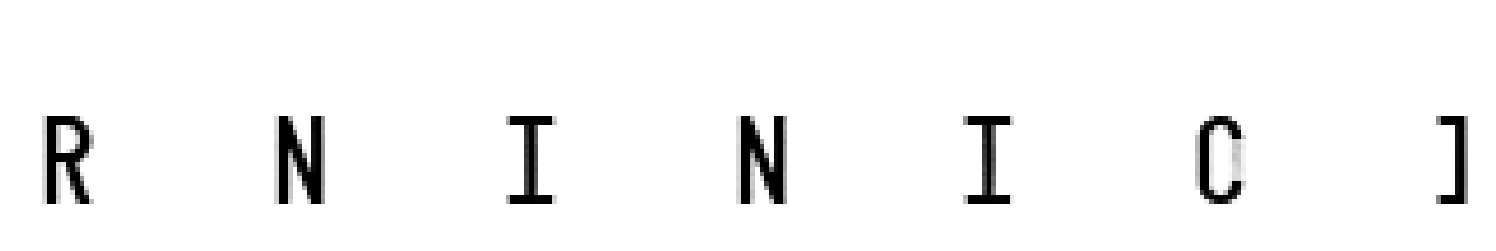

In [11]:
fig, axes = plt.subplots(1, 7, figsize=(20, 3))
for i in range(7):
    axes[i].imshow(X[i].reshape(50, 25), cmap='gray')
    axes[i].axis('off')
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X)
batch_size = 64
augmented_data_generator = datagen.flow(X, Y, batch_size=batch_size)

In [13]:
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') == 1.0:
            print("\nReached 100% accuracy, stopping training!")
            self.model.stop_training = True
        
        if logs.get('val_accuracy') == 1.0:
            print("\nReached 100% accuracy on val, stopping training!")
            self.model.stop_training = True

checkpoint = ModelCheckpoint(
    'classifier_full_trained_best.tf',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [14]:
stop_training_callback = StopTrainingCallback()
classifier.fit(augmented_data_generator,steps_per_epoch=len(X) // batch_size, epochs=500, 
               callbacks=[stop_training_callback,checkpoint],
               validation_data=(X, Y))

Epoch 1/500


2024-08-02 16:07:55.013991: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x70aa6c03cc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-02 16:07:55.014025: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-02 16:07:55.018768: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-02 16:07:55.134490: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


861/864 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9869
Epoch 1: val_accuracy improved from -inf to 0.98818, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 22s 21ms/step - loss: 0.0663 - accuracy: 0.9870 - val_loss: 0.0581 - val_accuracy: 0.9882
Epoch 2/500
863/864 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9886
Epoch 2: val_accuracy improved from 0.98818 to 0.98892, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 21ms/step - loss: 0.0530 - accuracy: 0.9887 - val_loss: 0.0580 - val_accuracy: 0.9889
Epoch 3/500
863/864 [============================>.] - ETA: 0s - loss: 0.0496 - accuracy: 0.9888
Epoch 3: val_accuracy improved from 0.98892 to 0.98973, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 21ms/step - loss: 0.0495 - accuracy: 0.9888 - val_loss: 0.0460 - val_accuracy: 0.9897
Epoch 4/500
861/864 [============================>.] - ETA: 0s - loss: 0.0482 - accuracy: 0.9890
Epoch 4: val_accuracy did not improve from 0.98973
864/864 [==============================] - 16s 19ms/step - loss: 0.0481 - accuracy: 0.9891 - val_loss: 0.0576 - val_accuracy: 0.9879
Epoch 5/500
862/864 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9889
Epoch 5: val_accuracy did not improve from 0.98973
864/864 [==============================] - 16s 19ms/step - loss: 0.0454 - accuracy: 0.9889 - val_loss: 0.0483 - val_accuracy: 0.9896
Epoch 6/500
861/864 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9895
Epoch 6: val_accuracy did not improve from 0.98973
864/864 [==============================] - 16s 19ms/step - loss: 0.0458 - accuracy: 0.9895 - val_loss: 0.0473 - val_accuracy: 0.9897
Epoch 7/500
861/864 [===

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 20ms/step - loss: 0.0400 - accuracy: 0.9902 - val_loss: 0.0422 - val_accuracy: 0.9904
Epoch 12/500
864/864 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9903
Epoch 12: val_accuracy did not improve from 0.99042
864/864 [==============================] - 16s 19ms/step - loss: 0.0391 - accuracy: 0.9903 - val_loss: 0.0957 - val_accuracy: 0.9682
Epoch 13/500
864/864 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9904
Epoch 13: val_accuracy did not improve from 0.99042
864/864 [==============================] - 16s 19ms/step - loss: 0.0393 - accuracy: 0.9904 - val_loss: 0.0553 - val_accuracy: 0.9857
Epoch 14/500
863/864 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9903
Epoch 14: val_accuracy did not improve from 0.99042
864/864 [==============================] - 16s 19ms/step - loss: 0.0377 - accuracy: 0.9903 - val_loss: 0.3351 - val_accuracy: 0.8625
Epoch 15/500
862/8

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 21ms/step - loss: 0.0368 - accuracy: 0.9908 - val_loss: 0.0356 - val_accuracy: 0.9906
Epoch 19/500
863/864 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.9908
Epoch 19: val_accuracy did not improve from 0.99064
864/864 [==============================] - 16s 19ms/step - loss: 0.0358 - accuracy: 0.9908 - val_loss: 0.0388 - val_accuracy: 0.9901
Epoch 20/500
863/864 [============================>.] - ETA: 0s - loss: 0.0357 - accuracy: 0.9906
Epoch 20: val_accuracy improved from 0.99064 to 0.99138, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 17s 20ms/step - loss: 0.0357 - accuracy: 0.9906 - val_loss: 0.0327 - val_accuracy: 0.9914
Epoch 21/500
863/864 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9906
Epoch 21: val_accuracy did not improve from 0.99138
864/864 [==============================] - 16s 19ms/step - loss: 0.0352 - accuracy: 0.9906 - val_loss: 1.0687 - val_accuracy: 0.6747
Epoch 22/500
861/864 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.9908
Epoch 22: val_accuracy did not improve from 0.99138
864/864 [==============================] - 16s 19ms/step - loss: 0.0357 - accuracy: 0.9908 - val_loss: 0.0384 - val_accuracy: 0.9908
Epoch 23/500
864/864 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9910
Epoch 23: val_accuracy did not improve from 0.99138
864/864 [==============================] - 16s 19ms/step - loss: 0.0342 - accuracy: 0.9910 - val_loss: 0.3172 - val_accuracy: 0.8899
Epoch 24/500
864/8

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 17s 20ms/step - loss: 0.0308 - accuracy: 0.9913 - val_loss: 0.0388 - val_accuracy: 0.9914
Epoch 38/500
862/864 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9916
Epoch 38: val_accuracy did not improve from 0.99145
864/864 [==============================] - 16s 19ms/step - loss: 0.0305 - accuracy: 0.9915 - val_loss: 0.3811 - val_accuracy: 0.9061
Epoch 39/500
864/864 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9914
Epoch 39: val_accuracy did not improve from 0.99145
864/864 [==============================] - 16s 19ms/step - loss: 0.0306 - accuracy: 0.9914 - val_loss: 0.6006 - val_accuracy: 0.7920
Epoch 40/500
864/864 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9917
Epoch 40: val_accuracy improved from 0.99145 to 0.99167, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 20ms/step - loss: 0.0301 - accuracy: 0.9917 - val_loss: 0.0332 - val_accuracy: 0.9917
Epoch 41/500
861/864 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9918
Epoch 41: val_accuracy improved from 0.99167 to 0.99176, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 20ms/step - loss: 0.0298 - accuracy: 0.9918 - val_loss: 0.0344 - val_accuracy: 0.9918
Epoch 42/500
862/864 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.9916
Epoch 42: val_accuracy did not improve from 0.99176
864/864 [==============================] - 16s 19ms/step - loss: 0.0296 - accuracy: 0.9916 - val_loss: 0.0326 - val_accuracy: 0.9914
Epoch 43/500
863/864 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9917
Epoch 43: val_accuracy did not improve from 0.99176
864/864 [==============================] - 16s 19ms/step - loss: 0.0298 - accuracy: 0.9917 - val_loss: 0.0375 - val_accuracy: 0.9915
Epoch 44/500
864/864 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9917
Epoch 44: val_accuracy improved from 0.99176 to 0.99186, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 17s 20ms/step - loss: 0.0299 - accuracy: 0.9917 - val_loss: 0.0321 - val_accuracy: 0.9919
Epoch 45/500
861/864 [============================>.] - ETA: 0s - loss: 0.0289 - accuracy: 0.9921
Epoch 45: val_accuracy did not improve from 0.99186
864/864 [==============================] - 16s 19ms/step - loss: 0.0290 - accuracy: 0.9921 - val_loss: 0.0452 - val_accuracy: 0.9905
Epoch 46/500
863/864 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9915
Epoch 46: val_accuracy did not improve from 0.99186
864/864 [==============================] - 16s 18ms/step - loss: 0.0298 - accuracy: 0.9915 - val_loss: 0.0374 - val_accuracy: 0.9915
Epoch 47/500
862/864 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9919
Epoch 47: val_accuracy improved from 0.99186 to 0.99226, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 21ms/step - loss: 0.0289 - accuracy: 0.9919 - val_loss: 0.0304 - val_accuracy: 0.9923
Epoch 48/500
864/864 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9917
Epoch 48: val_accuracy did not improve from 0.99226
864/864 [==============================] - 16s 19ms/step - loss: 0.0292 - accuracy: 0.9917 - val_loss: 0.0432 - val_accuracy: 0.9907
Epoch 49/500
863/864 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9920
Epoch 49: val_accuracy did not improve from 0.99226
864/864 [==============================] - 16s 19ms/step - loss: 0.0284 - accuracy: 0.9920 - val_loss: 0.8192 - val_accuracy: 0.8689
Epoch 50/500
862/864 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9918
Epoch 50: val_accuracy did not improve from 0.99226
864/864 [==============================] - 16s 19ms/step - loss: 0.0289 - accuracy: 0.9919 - val_loss: 0.0844 - val_accuracy: 0.9800
Epoch 51/500
862/8

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 17s 20ms/step - loss: 0.0272 - accuracy: 0.9920 - val_loss: 0.0273 - val_accuracy: 0.9924
Epoch 64/500
863/864 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.9920
Epoch 64: val_accuracy did not improve from 0.99237
864/864 [==============================] - 16s 19ms/step - loss: 0.0275 - accuracy: 0.9920 - val_loss: 0.0378 - val_accuracy: 0.9914
Epoch 65/500
863/864 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9923
Epoch 65: val_accuracy did not improve from 0.99237
864/864 [==============================] - 16s 19ms/step - loss: 0.0271 - accuracy: 0.9923 - val_loss: 0.0326 - val_accuracy: 0.9907
Epoch 66/500
861/864 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9923
Epoch 66: val_accuracy did not improve from 0.99237
864/864 [==============================] - 16s 18ms/step - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.0286 - val_accuracy: 0.9923
Epoch 67/500
863/8

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 18s 21ms/step - loss: 0.0254 - accuracy: 0.9925 - val_loss: 0.0252 - val_accuracy: 0.9927
Epoch 85/500
864/864 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9926
Epoch 85: val_accuracy did not improve from 0.99268
864/864 [==============================] - 16s 19ms/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 0.0579 - val_accuracy: 0.9839
Epoch 86/500
862/864 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9923
Epoch 86: val_accuracy did not improve from 0.99268
864/864 [==============================] - 16s 18ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.0284 - val_accuracy: 0.9926
Epoch 87/500
862/864 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9927
Epoch 87: val_accuracy did not improve from 0.99268
864/864 [==============================] - 16s 18ms/step - loss: 0.0255 - accuracy: 0.9927 - val_loss: 0.1279 - val_accuracy: 0.9619
Epoch 88/500
862/8

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


864/864 [==============================] - 17s 20ms/step - loss: 0.0250 - accuracy: 0.9924 - val_loss: 0.0284 - val_accuracy: 0.9929
Epoch 90/500
864/864 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9927
Epoch 90: val_accuracy did not improve from 0.99293
864/864 [==============================] - 16s 19ms/step - loss: 0.0250 - accuracy: 0.9927 - val_loss: 0.0450 - val_accuracy: 0.9887
Epoch 91/500
862/864 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9924
Epoch 91: val_accuracy did not improve from 0.99293
864/864 [==============================] - 16s 19ms/step - loss: 0.0253 - accuracy: 0.9924 - val_loss: 0.0266 - val_accuracy: 0.9925
Epoch 92/500
861/864 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9927
Epoch 92: val_accuracy did not improve from 0.99293
864/864 [==============================] - 16s 19ms/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 0.0372 - val_accuracy: 0.9912
Epoch 93/500
624/8

KeyboardInterrupt: 

In [15]:
classifier.save("classifier_full_trained.tf")

INFO:tensorflow:Assets written to: classifier_full_trained.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained.tf/assets


In [16]:
classifier.evaluate(X,Y)

1729/1729 [==============================] - 5s 3ms/step - loss: 1.7161 - accuracy: 0.6909


[1.716137409210205, 0.6909281611442566]